In [1]:
from integrators import contact as ic
from integrators.common import rk4
from lienard import integrator as li
from lienard import models as lm

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6b(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1b):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6e(system, dt, p, q, s, t, a=ic.e_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as si
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import progressbar

In [3]:
def err(x, y):
    return np.maximum.accumulate(np.abs(x-y))

## Forced Van Der Pol Oscillator

Forced Van der Pol Oscillator from: "Explicit methods in extended phase space for inseparable Hamiltonian problems", 
doi:10.1007/s10569-014-9597-9
$f(q) = - \epsilon (1-q^2)$ and $F(q,t) = q - A \cos(\frac{2 \pi t}{P})$.
Simulations parameters:

$\tau = 0.02$

$t_f = 500$

$\mu = 5$

$A = 5$

$P=\frac{2 \pi}{2.463}$

In [4]:
from scipy import integrate as si

def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, abs(x[i]-y[i]))
    return errv

In [5]:
def ivp_vdp(y, t, mu, a, omega):
    return [
        y[1],
        mu*(1-y[0]**2)*y[1] - y[0] + a*np.cos(omega*t)
    ]

In [6]:
tspan = np.arange(0, 500, 0.02)
y_init, params = [2, 2], (5, 5, 2.463)

y_odeint, info = si.odeint(ivp_vdp, y_init, tspan, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 478504, number of Jacobian evaluations: 9985


In [7]:
vdp = lm.VanDerPol(*params)
q0, p0, s0 = y_init[0], 0, y_init[1]

sol, sols, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, vdp, tspan, p0, q0, s0)

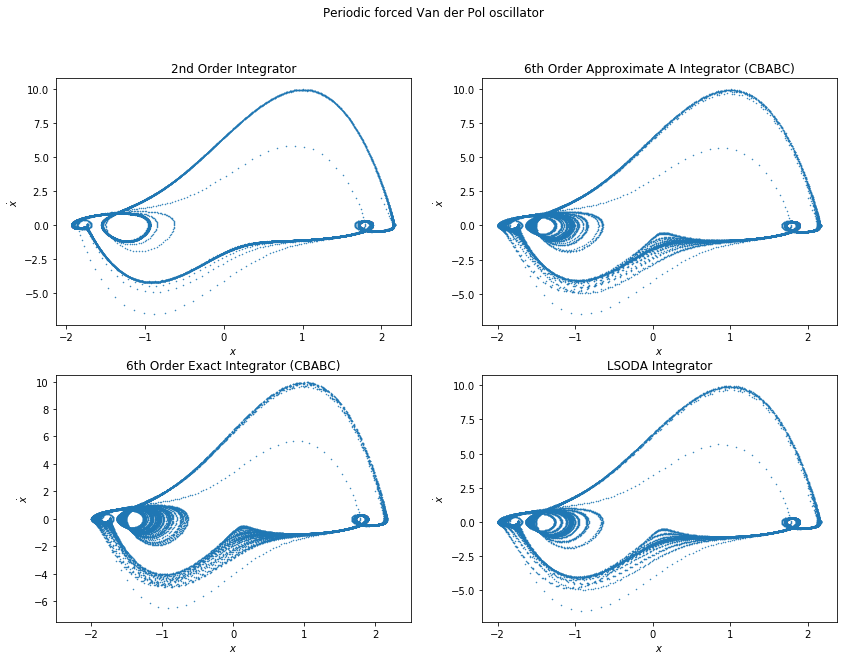

In [16]:
plt.figure(figsize=(14,10))

plt.suptitle("Periodic forced Van der Pol oscillator")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], sols, '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order Approximate A Integrator (CBABC)")
plt.plot(solm[:,1], solms,'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order Exact Integrator (CBABC)")
plt.plot(sol1[:,1], sol1s,'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")
plt.xlim((-2.5,2.5))
plt.ylim((-7.5,10.5))

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

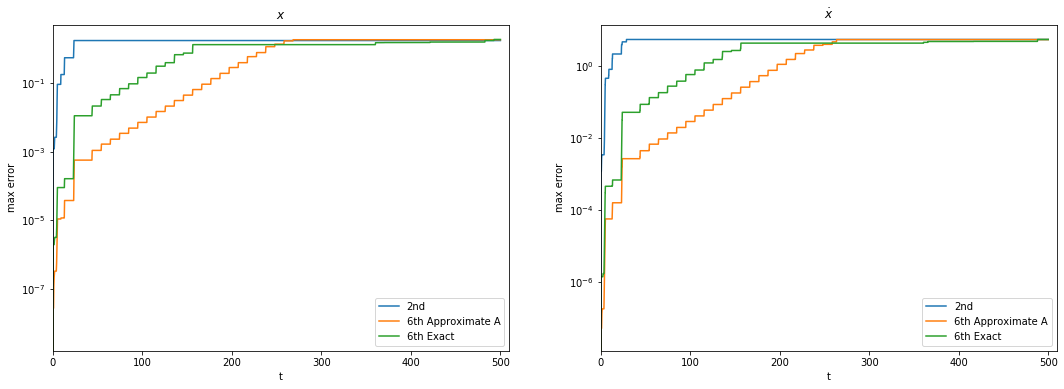

In [9]:
plt.figure(figsize=(18,6))

cut = 0
plt.subplot("121")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
plt.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label='6th Approximate A')
plt.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label='6th Exact')
plt.yscale('log')
plt.xlim(0,510)
plt.legend(loc='lower right')

plt.subplot("122")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sols,y_odeint[:,1]),label="2nd")
plt.plot(tspan,
         err(solms,y_odeint[:,1]),label="6th Approximate A")
plt.plot(tspan,
         err(sol1s,y_odeint[:,1]),label="6th Exact")
plt.yscale('log')
plt.xlim(0,510)
plt.legend(loc='lower right')

plt.show()

# Bifurcation cascade

In [10]:
def bif_cascade(dt, tf=500, ms=1.2):
    fig = plt.figure(figsize=(14,10))

    for i,w in enumerate([2.457, 2.460, 2.462, 2.463]):
        tspan = np.arange(0, tf, dt)
        y_init, params = [2, 2], (5, 5, w)
        q0, p0, s0 = y_init[0], 0, y_init[1]
        vdp = lm.VanDerPol(*params)

        y_odeint = si.odeint(ivp_vdp, y_init, tspan, params, rtol=1e-13, atol=1e-15)
        sol2, sols2, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
        sol4, sols4, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)


        ax = fig.add_subplot(221 + i)
        ax.title.set_text("$\tau = {:4.3f}, \omega = {:4.3f}, t \in [0,{}]$".format(dt, w, tf))
        ax.plot(sol2[:,1], sols2, '.', markersize=ms, label="2nd", color="C2")
        ax.plot(sol4[:,1], sols4, '.', markersize=ms, label="6th A", color="C1")

        ax.set_xlabel("$x$")
        ax.set_ylabel("$\dot{x}$")
        ax.legend(loc="upper left")

        axins = inset_axes(ax, width="30%", height="30%", loc=4)
        axins.plot(y_odeint[:,0], y_odeint[:,1], '.', markersize=ms, label="LSODA", color="C0")

    return fig

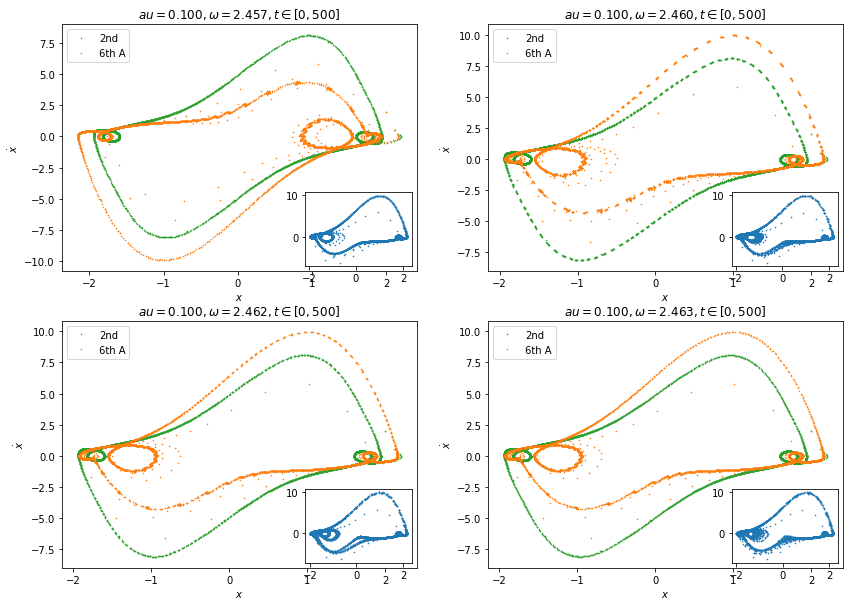

In [11]:
fig = bif_cascade(0.1)

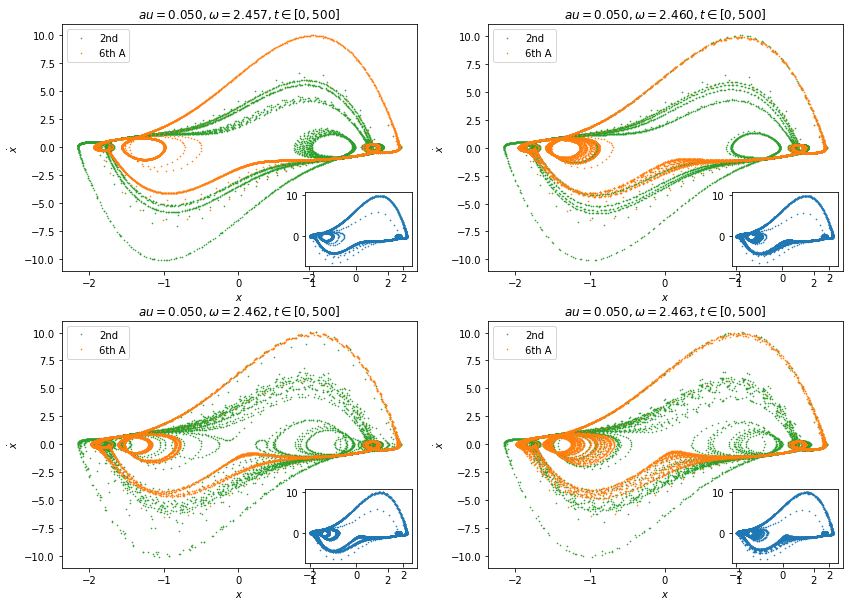

In [12]:
fig = bif_cascade(0.05)

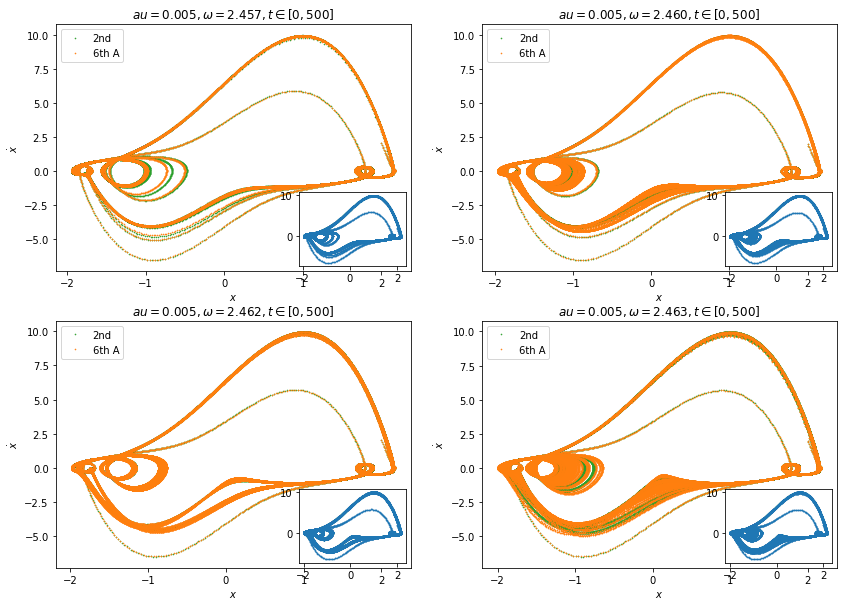

In [13]:
fig = bif_cascade(0.005)

In [14]:
def bif_cascade_comparison(dts, tf=500, ms=1.2):
    fig = plt.figure(figsize=(14,5*len(dts)))
    
    for i,dt in enumerate(dts):
        tspan = np.arange(0, tf, dt)

        for j,w in enumerate([2.457, 2.463]):
            
            y_init, params = [2, 2], (5, 5, w)
            q0, p0, s0 = y_init[0], 0, y_init[1]
            vdp = lm.VanDerPol(*params)

            y_odeint = si.odeint(ivp_vdp, y_init, tspan, params, rtol=1e-13, atol=1e-15)
            sol2, sols2, _ = ic.integrate(li.step1, vdp, tspan, p0, q0, s0)
            sol4, sols4, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)

            ax = fig.add_subplot(21 + j + 2*i + 100 * len(dts))
            ax.title.set_text("$\\tau = {:4.3f}, \omega = {:4.3f}, t \in [0,{}]$".format(dt, w, tf))
            ax.plot(sol2[:,1], sols2, '.', markersize=ms, label="2nd", color="C2")
            ax.plot(sol4[:,1], sols4, '.', markersize=ms, label="6th A", color="C1")

            ax.set_xlabel("$x$")
            ax.set_ylabel("$\dot{x}$")
            ax.legend(loc="upper left")

            axins = inset_axes(ax, width="30%", height="30%", loc=4)
            axins.plot(y_odeint[:,0], y_odeint[:,1], '.', markersize=ms, label="LSODA", color="C0")
            axins.set_xticks([])
            axins.set_yticks([])

    return fig

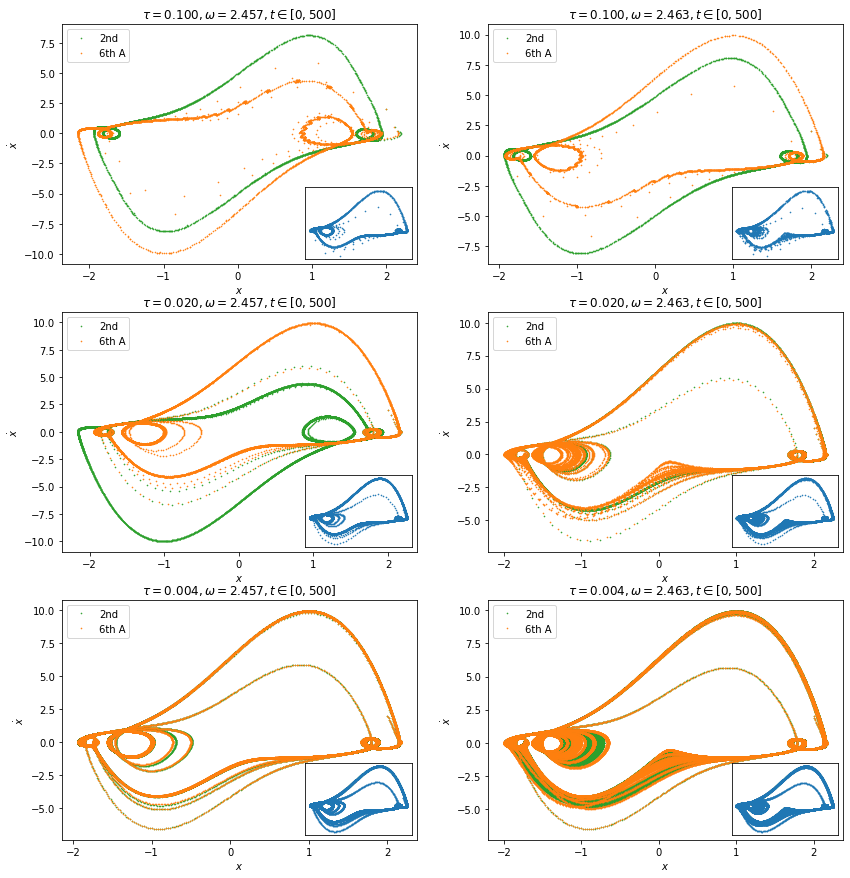

In [15]:
fig = bif_cascade_comparison([0.1,0.02,0.004])